<a href="https://colab.research.google.com/github/RafaelBNN/if697/blob/main/ProjetoIF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importação das Bibliotecas

In [1]:
# Importando as bibliotecas necessarias

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

!pip install fancyimpute # Talvez seja necessario descomentar esta linha
from fancyimpute import KNN

     |████████████████████████████████| 22.3MB 4.8MB/s 
     |████████████████████████████████| 1.3MB 32.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 27.4MB 124kB/s 
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736208 sha256=ff85557a65c93efa1851015cd5bcea6c1026a6250663e0b2dd270e540f8d5141
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Created wheel for knnimpute: filename=knnimpute-0.1.0-cp37-none-any.whl size=11354 sha256=e190fdc33281515635e8688a89539d0d39785a5ff3faeaf02a7f8ef379e85efb
  Stored in directory: /root/.cache/pip/wheels/a3/92/31/c3f8864714e9938396c3a68d8c542531f7e2d7862bb750b2e3
Successfully built knnimpute
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/RafaelBNN/datasets/main/powerlifting3.csv") # Carregamos o dataframe

# 1. Introdução e Coleta de Dados

In [ ]:
import requests
from io import BytesIO
from PIL import Image
url = 'https://raw.githubusercontent.com/RafaelBNN/if697/main/sbd2.jpg?token=AKYEI55RUJLWBUN6O3TY4DLA2DFH4'
page = requests.get(url)

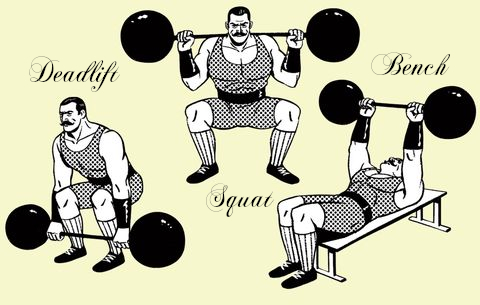

In [ ]:
#Image.open(BytesIO(page.content)) # Por algum motivo esta celula da erro as vezes

O *powerlifting* é um esporte de força individual que consiste em 3 levantamentos básicos: *squat* (agachamento), *bench press* (supino) e *deadlift* (levantamento terra). Como no *weightlifting* olímpico, cada competidor tem direito a 3 tentativas em cada evento, e o objetivo é executar corretamente o exercício uma única vez com a maior carga possível. A maior carga erguida com sucesso é computada para o resultado final. Aquele que tiver o maior somatório dos 3 eventos, vence naquela categoria.

O dataset que será analisado foi retirado do site da [Open Powerlifting](https://www.openpowerlifting.org/) e contém dados coletados de várias competições oficias. Nosso objetivo será investigar os dados, apresentar estatísticas descritivas e realizar testes de hipótese, a fim de obter *insights* relevantes sobre o esporte.

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/RafaelBNN/datasets/main/powerlifting3.csv") # Carregamos o dataframe

In [ ]:
df.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,692083,Hayden Fulwood,M,SBD,Raw,18.0,18-19,MR-T3,88.0,90,NaN,NaN,NaN,NaN,167.50,NaN,NaN,NaN,NaN,122.50,NaN,NaN,NaN,NaN,227.50,517.50,1,334.25,354.31,322.27,482.79,Yes,USA,USAPL,2013-04-27,USA,AL,S.E HS State Wars
1,621012,Jozef Slimák,M,B,Multi-ply,46.0,45-49,M-M2,82.2,82.5,NaN,NaN,NaN,NaN,NaN,165.0,180.0,-190.0,NaN,180.00,NaN,NaN,NaN,NaN,NaN,180.00,1,120.85,129.06,116.68,571.78,NaN,Slovakia,WPC,2012-11-06,USA,NV,World Championships
2,164449,Chase Garrett,M,D,Raw,NaN,13-15,Teenage 13-15,44.0,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic
3,353419,Edgar Rodea,M,SBD,Single-ply,NaN,NaN,Boys,92.9,99.7,NaN,NaN,NaN,NaN,204.12,NaN,NaN,NaN,NaN,129.27,NaN,NaN,NaN,NaN,185.97,519.36,1,326.42,326.42,314.34,420.04,Yes,NaN,THSPA,2017-01-28,USA,TX,Santo Meet
4,128144,K. Kaufman,M,B,Raw,NaN,NaN,Open,90.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.15,NaN,NaN,NaN,NaN,NaN,145.15,6,92.66,92.66,89.30,558.46,NaN,NaN,USPF,1979-12-08,USA,ND,3rd Annual Midwestern Bench Press Championships


Descrição dos dados:

* `Name`: nome
* `Sex`: sexo
* `Event`: o(s) evento(s) em que competiu (S = squat, B = bench press, D = deadlift)
* `Equipment`: o equipamento utilizado
* `Age`: idade
* `AgeClass`: a classe de idade em que competiu
* `Division`: a divisão em que competiu
* `BodyweightKg`: o peso do corpo em kg
* `WeightClassKg`: a classe de peso em que competiu, similar a `Division`
* `SquatNKg`: a carga levantada no agachamento na *N*-ésima tentativa, em kg. Valores negativos significam tentativas falhas
* `BenchNKg`: a carga levantada no supino na *N*-ésima tentativa, em kg. Valores negativos significam tentativas falhas
* `DeadliftNKg`: a carga levantada no levantamento terra na *N*-ésima tentativa, em kg. Valores negativos significam tentativas falhas
* `Best3SquatKg`: o maior peso que levantou naquela competição no agachamento
* `Best3BenchKg`: o maior peso que levantou naquela competição no supino
* `Best3DeadliftKg`: o maior peso que levantou naquela competição no levantamento terra
* `TotalKg`: a soma de `Best3SquatKg`, `Best3BenchKg` e `Best3DeadliftKg`. Se algum desses valores for negativo, `TotalKg` é anulado
* `Place`: a colocação naquela competição. Também indica se o competidor foi desqualificado, não participou ou não foi elegível a premiação
* `Wilks`, `McCulloch` e `Glossbrenner`: coeficientes que medem a força do atleta de acordo com sexo, peso corporal, idade e peso total levantado. Buscam determinar o melhor atleta dentre todas as categorias
* `IPFPoints`: pontuação na *International Powerlifting Federation*
* `Tested`: se a competição foi testada para anti-doping ou não
* `Country`: país que representa
* `Federation`: federação que organizou a competição
* `Date`: data da competição
* `MeetCountry`: país da competição
* `MeetState`: estado da competição
* `MeetName`: nome da competição


# 2. Pré-processamento

O pré-processamento é um dos passos mais importantes na análise descritiva e exploratória de dados. Nessa etapa, os dados são tratados de modo que informações discrepantes, insconsistentes ou incorretas sejam estudadas e/ou removidas. Isso facilita a interpretação e evita incoerências na análise.

Essa etapa pode ser dividida em 5 subetapas:
* Definição de Tipos
* Tratamento de Dados Ausentes
* Normalização
* Discretização
* Limpeza de Dados

Vamos, então, pôr em prática cada uma delas passo a passo.

## Definição de Tipos

O Ajuste de Tipos serve para estabelecer os tipos dos dados de acordo com a necessidade daquela análise. A célula a seguir expõe os tipos colocados automaticamente pela biblioteca.

In [3]:
df.dtypes

Unnamed: 0           int64
Name                object
Sex                 object
Event               object
Equipment           object
Age                float64
AgeClass            object
Division            object
BodyweightKg       float64
WeightClassKg       object
Squat1Kg           float64
Squat2Kg           float64
Squat3Kg           float64
Squat4Kg           float64
Best3SquatKg       float64
Bench1Kg           float64
Bench2Kg           float64
Bench3Kg           float64
Bench4Kg           float64
Best3BenchKg       float64
Deadlift1Kg        float64
Deadlift2Kg        float64
Deadlift3Kg        float64
Deadlift4Kg        float64
Best3DeadliftKg    float64
TotalKg            float64
Place               object
Wilks              float64
McCulloch          float64
Glossbrenner       float64
IPFPoints          float64
Tested              object
Country             object
Federation          object
Date                object
MeetCountry         object
MeetState           object
M

A partir daí, notamos que vários atributos  estão listados como `object`. No entanto, muitos deles se encaixariam melhor no tipo `string` ou `category`, facilitando a interpretação deles. As células a seguir tratam desses casos.

In [4]:
df['Name'] = df['Name'].astype('string')
df['Sex'] = df['Sex'].astype('category')                        # astype('char')
df['Event'] = df['Event'].astype('category')                    # astype('string')
df['Equipment'] = df['Equipment'].astype('category')
df['AgeClass'] = df['AgeClass'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')
df['Place'] = df['Place'].astype('category')                    # astype('int64')
df['Tested'] = df['Tested'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Federation'] = df['Federation'].astype('category')
df['Date'] = df['Date'].astype('category')
df['MeetCountry'] = df['MeetCountry'].astype('category')
df['MeetState'] = df['MeetState'].astype('category')
df['MeetName'] = df['MeetName'].astype('category')

df['Event'].dtype, df['Equipment'].dtype # Visualizacao de um caso importante

(CategoricalDtype(categories=['B', 'BD', 'D', 'S', 'SB', 'SBD', 'SD'], ordered=False),
 CategoricalDtype(categories=['Multi-ply', 'Raw', 'Single-ply', 'Wraps'], ordered=False))

In [5]:
df['Place'].dtype

CategoricalDtype(categories=['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '20', '21', '22', '23', '24', '25', '26', '27',
                  '28', '29', '3', '30', '32', '33', '35', '36', '38', '4',
                  '43', '44', '47', '5', '50', '51', '54', '55', '56', '57',
                  '58', '6', '65', '7', '8', '82', '84', '9', 'DD', 'DQ', 'G',
                  'NS'],
                 ordered=False)

In [6]:
df.dtypes

Unnamed: 0            int64
Name                 string
Sex                category
Event              category
Equipment          category
Age                 float64
AgeClass           category
Division           category
BodyweightKg        float64
WeightClassKg      category
Squat1Kg            float64
Squat2Kg            float64
Squat3Kg            float64
Squat4Kg            float64
Best3SquatKg        float64
Bench1Kg            float64
Bench2Kg            float64
Bench3Kg            float64
Bench4Kg            float64
Best3BenchKg        float64
Deadlift1Kg         float64
Deadlift2Kg         float64
Deadlift3Kg         float64
Deadlift4Kg         float64
Best3DeadliftKg     float64
TotalKg             float64
Place              category
Wilks               float64
McCulloch           float64
Glossbrenner        float64
IPFPoints           float64
Tested             category
Country            category
Federation         category
Date               category
MeetCountry        c

Assim, atualizamos os tipos dos dados. Isso vai favorecer a investigação dos dados mais à frente.

## Tratamento de Dados Ausentes

O Tratamento de Dados Ausentes mostra-se bastante importante nos casos em que registros que queremos estudar possuem atributos faltantes. Isso pode limitar bastante a análise dependendo da importância daquele atributo.

Nesta etapa, faremos exatamente isso. Vamos estudar dados ausentes e tratá-los de acordo com a necessidade de cada caso.

In [ ]:
df.isnull().sum(axis = 0)/len(df)

Unnamed: 0         0.00000
Name               0.00000
Sex                0.00000
Event              0.00000
Equipment          0.00000
Age                0.46925
AgeClass           0.44795
Division           0.00505
BodyweightKg       0.01240
WeightClassKg      0.00930
Squat1Kg           0.76470
Squat2Kg           0.76740
Squat3Kg           0.77390
Squat4Kg           0.99705
Best3SquatKg       0.27550
Bench1Kg           0.64945
Bench2Kg           0.65375
Bench3Kg           0.66385
Bench4Kg           0.99360
Best3BenchKg       0.10485
Deadlift1Kg        0.74850
Deadlift2Kg        0.75340
Deadlift3Kg        0.76355
Deadlift4Kg        0.99480
Best3DeadliftKg    0.24295
TotalKg            0.07830
Place              0.00000
Wilks              0.08425
McCulloch          0.08435
Glossbrenner       0.08425
IPFPoints          0.10560
Tested             0.22805
Country            0.72445
Federation         0.00000
Date               0.00000
MeetCountry        0.00000
MeetState          0.34105
M

### `Place`

Primeiramente, vamos examinar a coluna `Place`. Além de mostrar a colocação dos competidores, como se é esperado, essa coluna especifica casos em que o competidor não compareceu, não foi elegível a premiação ou foi desqualificado da competição por algum motivo. Isso é mostrado da seguinte forma:

In [7]:
df['Place'].cat.categories # Esse comando mostra as categorias de um dado atributo categorico

Index(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30',
       '32', '33', '35', '36', '38', '4', '43', '44', '47', '5', '50', '51',
       '54', '55', '56', '57', '58', '6', '65', '7', '8', '82', '84', '9',
       'DD', 'DQ', 'G', 'NS'],
      dtype='object')

* `G`: não elegível a premiação
* `DD`: desqualificado por doping
* `DQ`: desqualificado por outra razão
* `NS`: não compareceu

Investigaremos, agora, esses registros.

In [8]:
ddq = df[(df['Place']=='DQ') | (df['Place']=='DD') | (df['Place']=='NS')] # participantes desqualificados ou que nao compareceram
ddq.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
26,1357114,Amanda Quatrochi,F,B,Multi-ply,14.0,13-15,FTX,54.40,56,NaN,NaN,NaN,NaN,NaN,-62.5,-62.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DQ,NaN,NaN,NaN,NaN,NaN,NaN,UPA,2007-09-01,USA,IA,Bench Bash For Cash on the MS
28,866962,Tim Sparkes,M,D,Single-ply,47.0,45-49,Open,105.91,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-320.0,NaN,DQ,NaN,NaN,NaN,NaN,NaN,USA,USPA,2014-09-19,USA,NV,Mr Olympia Powerlifting Benchpress and Deadlif...
30,273953,Victor Aguilar,M,SBD,Single-ply,NaN,NaN,Boys,87.72,89.8,NaN,NaN,NaN,NaN,219.99,NaN,NaN,NaN,NaN,129.27,NaN,NaN,NaN,NaN,NaN,NaN,DQ,NaN,NaN,NaN,NaN,Yes,NaN,THSPA,2012-01-28,USA,TX,Greyhound Invitational
39,753723,Justin Collins,M,SBD,Raw,31.5,24-34,MR-O,161.00,120+,-227.5,-227.5,-227.5,NaN,NaN,185.0,195.0,-202.5,NaN,195.00,237.5,250.0,-262.5,NaN,250.0,NaN,DQ,NaN,NaN,NaN,NaN,Yes,NaN,USAPL,2016-07-30,USA,OH,Ohio State Championship
41,852146,Alvin Waldon,M,B,Single-ply,49.0,45-49,Open,110.00,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DQ,NaN,NaN,NaN,NaN,NaN,USA,USPF,2000-11-11,USA,CA,USA National Powerlifting and Bench Press Cham...


In [9]:
print('Porcentagem de competidores desqualificados ou que não compareceram:', len(ddq)/len(df))

Porcentagem de competidores desqualificados ou que não compareceram: 0.0783


In [10]:
dg = df[df['Place']=='G'] # participantes nao elegiveis a premiacao
dg.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
289,669746,Isabella Martin,F,SBD,Raw,8.5,5-12,FR-G,35.80,47,42.5,47.5,-50.0,NaN,47.5,22.5,25.0,27.5,NaN,27.5,63.5,67.5,72.5,NaN,72.5,147.5,G,232.71,346.74,216.71,NaN,Yes,USA,USAPL,2018-05-05,USA,MO,Missouri State Championships
867,239655,João Arsénio,M,SBD,Single-ply,NaN,NaN,M-E-G,79.00,82.5,NaN,NaN,NaN,NaN,250.0,NaN,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,245.0,620.0,G,426.68,426.68,412.28,537.85,Yes,NaN,EPA,2003-12-07,England,NaN,East Midlands Divisional Championships
1024,731205,Gideon Kluge,M,SBD,Raw,23.5,24-34,MR-G,99.30,105,230.0,240.0,245.0,NaN,245.0,142.5,150.0,155.0,NaN,155.0,285.0,-305.0,-305.0,NaN,285.0,685.0,G,418.07,418.07,401.88,617.08,Yes,NaN,USAPL,2017-04-29,USA,NE,Nebraska State Championships
1330,1362414,Tim Wilke,M,SBD,Multi-ply,36.0,35-39,MS,109.45,110,285.0,317.5,NaN,NaN,317.5,170.0,177.5,182.5,NaN,182.5,280.0,295.0,-300.0,NaN,295.0,795.0,G,468.58,468.58,448.95,562.70,NaN,NaN,UPA,2010-07-10,USA,IL,Illionois Powerlifting Championships
1375,888170,Gregory Costa,M,SBD,Raw,24.0,24-34,Open,96.00,100,NaN,NaN,NaN,NaN,245.0,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,NaN,290.0,695.0,G,430.29,430.29,414.02,640.67,Yes,USA,IPL,2018-11-08,USA,NV,Drug Tested World Championships


In [11]:
print('Porcentagem de competidores nao elegiveis a premiacao:', len(dg)/len(df))

Porcentagem de competidores nao elegiveis a premiacao: 0.0017


Percebemos, então, que há uma quantidade significativa de competidores que foram desqualificados. Esses casos têm a coluna `TotalKg` anulada por causa disso. Eles serão removidos para manter a integridade dos dados.

Por outro lado, constata-se que os competidores inaptos a receber premiação não têm a coluna `TotalKg` anulada. Esses competidores normalmente participam apenas para exibições e não parecem ter efeitos negativos sobre o dataframe. Portanto, esses casos não serão removidos.

In [12]:
df = df[(df['Place']!='DQ') & (df['Place']!='DD') & (df['Place']!='NS')] # Atualizando o dataframe

In [13]:
df.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,692083,Hayden Fulwood,M,SBD,Raw,18.0,18-19,MR-T3,88.0,90,NaN,NaN,NaN,NaN,167.50,NaN,NaN,NaN,NaN,122.50,NaN,NaN,NaN,NaN,227.50,517.50,1,334.25,354.31,322.27,482.79,Yes,USA,USAPL,2013-04-27,USA,AL,S.E HS State Wars
1,621012,Jozef Slimák,M,B,Multi-ply,46.0,45-49,M-M2,82.2,82.5,NaN,NaN,NaN,NaN,NaN,165.0,180.0,-190.0,NaN,180.00,NaN,NaN,NaN,NaN,NaN,180.00,1,120.85,129.06,116.68,571.78,NaN,Slovakia,WPC,2012-11-06,USA,NV,World Championships
2,164449,Chase Garrett,M,D,Raw,NaN,13-15,Teenage 13-15,44.0,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic
3,353419,Edgar Rodea,M,SBD,Single-ply,NaN,NaN,Boys,92.9,99.7,NaN,NaN,NaN,NaN,204.12,NaN,NaN,NaN,NaN,129.27,NaN,NaN,NaN,NaN,185.97,519.36,1,326.42,326.42,314.34,420.04,Yes,NaN,THSPA,2017-01-28,USA,TX,Santo Meet
4,128144,K. Kaufman,M,B,Raw,NaN,NaN,Open,90.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.15,NaN,NaN,NaN,NaN,NaN,145.15,6,92.66,92.66,89.30,558.46,NaN,NaN,USPF,1979-12-08,USA,ND,3rd Annual Midwestern Bench Press Championships


In [14]:
df[(df['Place']=='DQ') | (df['Place']=='DD') | (df['Place']=='NS')].head() # registros desqualificado no dataframe atualizado

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName


In [15]:
len(df), 20000-len(df), (20000-len(df))/20000

(18434, 1566, 0.0783)

Foram removidos, assim, 1566 registros inválidos, o que corresponde a ~8% do total de registros.

Abaixo, vamos verificar a quantidade de dados nulos após a remoção dos registros desqualificados.

In [ ]:
df.isnull().sum(axis = 0)/len(df)

Unnamed: 0         0.000000
Name               0.000000
Sex                0.000000
Event              0.000000
Equipment          0.000000
Age                0.458772
AgeClass           0.436693
Division           0.004882
BodyweightKg       0.006455
WeightClassKg      0.003526
Squat1Kg           0.757893
Squat2Kg           0.760334
Squat3Kg           0.766735
Squat4Kg           0.996799
Best3SquatKg       0.243789
Bench1Kg           0.639308
Bench2Kg           0.642671
Bench3Kg           0.652490
Bench4Kg           0.993111
Best3BenchKg       0.045948
Deadlift1Kg        0.735218
Deadlift2Kg        0.738961
Deadlift3Kg        0.749539
Deadlift4Kg        0.994521
Best3DeadliftKg    0.188890
TotalKg            0.000000
Place              0.000000
Wilks              0.006455
McCulloch          0.006564
Glossbrenner       0.006455
IPFPoints          0.029619
Tested             0.231746
Country            0.720896
Federation         0.000000
Date               0.000000
MeetCountry        0

Alguns comentários sobre esses resultados:
* Note que `Age` tem mais dados nulos que `AgeClass`. Podemos, portanto, fazer imputação nos casos em que `Age` é nulo mas `AgeClass` não é (uma ideia inicial é imputar `Age` a partir da média de `AgeClass`). Também seria interessante indicar quando o dado for imputado.
* Naturalmente, as colunas exclusivas de cada evento terão um grande número de dados ausentes, já que os competidores não participam necessariamente de todos os 3 eventos.
* Quanto maior o número da tentativa, mais dados nulos na coluna. Ex.: a coluna `Squat3Kg` tem mais dados nulos do que `Squat2Kg`. Isso acontece porque alguns atletas escolhem não realizar a terceira ou até mesmo a segunda tentativa. Isso é permitido e o resultado obtido é computado da mesma forma.
* `Squat4Kg` tem consideravelmente mais dados nulos do que `SquatNKg`. O motivo é que a maioria das competições não permite a 4ª tentativa (o mesmo acontece para `Bench4Kg` e `Deadlift4Kg`).
* As colunas `SquatNKg` têm consideravelmente mais dados nulos do que a coluna `Best3SquatKg`. Isso acontece porque algumas competições só computam as melhores tentativas.
* Os casos em que o atributo `Tested` é nulo podem indicar que o evento não foi testado, já que eventos testados tendem a salientar esse aspecto.


### `Squat4Kg`,`Bench4Kg` e `Deadlift4Kg`

Como mostrado anteriormente, é possível notar uma porcentagem excepcionalmente alta de dados nulos nas colunas `Squat4Kg`,`Bench4Kg` e `Deadlift4Kg`. Isso acontece porque poucas competições permitem a 4ª tentativa, e esta está reservada apenas a tentativas de recordes mundiais e não é computada para o resultado final. Vamos analisar essas colunas mais detalhadamente.

In [16]:
# numero de registros de participacao em cada evento (coluna de melhor tentativa nao nula)
ns = df['Best3SquatKg'].notnull().sum()     
nb = df['Best3BenchKg'].notnull().sum()     
nd = df['Best3DeadliftKg'].notnull().sum()  

# numero de registros de participacao em cada evento que nao realizaram 4a tentativa
ss = len(df[(df['Best3SquatKg'].notnull()) & (df['Squat4Kg'].isnull())])
bb = len(df[(df['Best3BenchKg'].notnull()) & (df['Bench4Kg'].isnull())])
dd = len(df[(df['Best3DeadliftKg'].notnull()) & (df['Deadlift4Kg'].isnull())])

print('Registros:')
print('Agachamento: ', ns)
print('Supino: ', nb)
print('Levantamento terra: ', nd)
print('')
print('Participou do evento mas nao realizou 4a tentativa:')
print('Agachamento: ', ss)
print('Supino: ', bb)
print('Levantamento terra: ', dd)
print('')
print('Porcentagem que participou do evento mas nao realizou 4a tentativa:')
print('Agachamento: ', round(ss/ns,3))
print('Supino: ', round(bb/nb,3))
print('Levantamento terra: ', round(dd/nd,3))

Registros:
Agachamento:  13940
Supino:  17587
Levantamento terra:  14952

Participou do evento mas nao realizou 4a tentativa:
Agachamento:  13881
Supino:  17460
Levantamento terra:  14851

Porcentagem que participou do evento mas nao realizou 4a tentativa:
Agachamento:  0.996
Supino:  0.993
Levantamento terra:  0.993


Dessa forma, vimos que mais de 99% dos registros de cada evento *não* inclui uma 4ª tentativa. Por isso, revela-se coerente a exclusão das colunas `Squat4Kg`, `Bench4Kg` e `Deadlift4Kg`.

In [17]:
df.drop(labels=['Squat4Kg','Bench4Kg','Deadlift4Kg'], axis=1, inplace=True)

In [18]:
df.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,692083,Hayden Fulwood,M,SBD,Raw,18.0,18-19,MR-T3,88.0,90,NaN,NaN,NaN,167.50,NaN,NaN,NaN,122.50,NaN,NaN,NaN,227.50,517.50,1,334.25,354.31,322.27,482.79,Yes,USA,USAPL,2013-04-27,USA,AL,S.E HS State Wars
1,621012,Jozef Slimák,M,B,Multi-ply,46.0,45-49,M-M2,82.2,82.5,NaN,NaN,NaN,NaN,165.0,180.0,-190.0,180.00,NaN,NaN,NaN,NaN,180.00,1,120.85,129.06,116.68,571.78,NaN,Slovakia,WPC,2012-11-06,USA,NV,World Championships
2,164449,Chase Garrett,M,D,Raw,NaN,13-15,Teenage 13-15,44.0,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic
3,353419,Edgar Rodea,M,SBD,Single-ply,NaN,NaN,Boys,92.9,99.7,NaN,NaN,NaN,204.12,NaN,NaN,NaN,129.27,NaN,NaN,NaN,185.97,519.36,1,326.42,326.42,314.34,420.04,Yes,NaN,THSPA,2017-01-28,USA,TX,Santo Meet
4,128144,K. Kaufman,M,B,Raw,NaN,NaN,Open,90.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.15,NaN,NaN,NaN,NaN,145.15,6,92.66,92.66,89.30,558.46,NaN,NaN,USPF,1979-12-08,USA,ND,3rd Annual Midwestern Bench Press Championships


Note que essas colunas não mais aparecem no dataframe.

### `Age` e `AgeClass`

Outra observação que fizemos foi sobre a diferença significativa entre a quantidade de dados nulos na coluna `Age` e na coluna `AgeClass`. Isso significa que alguns registros têm a coluna `Age` nula e a coluna `AgeClass` não-nula. Sendo assim, temos a oportunidade de imputare esses dados para ajudar na interpretação mais tarde. 

Uma ideia é imputar `Age` como a média dos limites de `AgeClass`. Também podemos fazer isso de acordo com os vizinhos mais próximos comparando a carga levantada, utilizando o algoritmo KNN. Vamos fazer a imputação das duas formas e compará-las para decidir a melhor.

Dito isso, investigaremos, inicialmente, os registros nulos e não-nulos de `Age` e `AgeClass`.

In [19]:
df_before = df.copy() # Faremos isso para comparar os valores ao final da imputacao
df_before['Age'].describe()

count    9977.000000
mean       31.404781
std        13.479156
min         0.500000
25%        21.000000
50%        27.500000
75%        39.500000
max        90.000000
Name: Age, dtype: float64

In [20]:
nullage = df['Age'].isnull().sum()
nullageclass = df['AgeClass'].isnull().sum()
notnullageclass = df['AgeClass'].notnull().sum()
nullagenotnullclass = len(df[(df['Age'].isnull())&(df['AgeClass'].notnull())])

print('Numero de valores nulos em "Age":', nullage)
print('Porcentagem do numero total de registros:', nullage/len(df))
print('')
print('Numero de valores nulos em "AgeClass":', nullageclass)
print('Porcentagem do numero total de registros:', nullageclass/len(df))
print('')
print('Numero de registros com "Age" nulo e "AgeClass" nao-nulo:', nullagenotnullclass)
print('Porcentagem do numero total de registros:', nullagenotnullclass/len(df))

Numero de valores nulos em "Age": 8457
Porcentagem do numero total de registros: 0.4587718346533579

Numero de valores nulos em "AgeClass": 8050
Porcentagem do numero total de registros: 0.43669306715851147

Numero de registros com "Age" nulo e "AgeClass" nao-nulo: 409
Porcentagem do numero total de registros: 0.022187262666811328


Concluímos, desta forma, que há 409 casos que podem ter a coluna `Age` imputada a partir de `AgeClass`, o que corresponde a 2,21% dos dados. A forma com que faremos isso será com a média dos limites da `AgeClass` daquele competidor. Ao final da imputação, vamos computar gráficos que vão dar uma ideia sobre a utilidade e impacto da imputação.

Vamos analisar esses casos.

In [ ]:
df[(df['Age'].isnull())&(df['AgeClass'].notnull())].head() # registros com Age nulo e AgeClass nao nulo

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
2,164449,Chase Garrett,M,D,Raw,NaN,13-15,Teenage 13-15,44.00,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic
16,1398692,Nick Russo,M,SBD,Wraps,NaN,20-23,Amateur Juniors 20-23,73.12,75,NaN,NaN,NaN,185.97,NaN,NaN,NaN,113.4,NaN,NaN,NaN,226.80,526.17,1,381.73,381.73,369.47,562.13,Yes,NaN,RPS,2015-03-21,USA,NY,Dominion
172,579972,Bjørn Henrik Kvamme,M,B,Single-ply,NaN,24-34,Open,85.50,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,NaN,NaN,NaN,NaN,175.00,1,114.83,114.83,110.78,546.42,Yes,NaN,NSF,2001-05-12,Norway,NaN,KM
185,1290906,Bruce Hellwinkel,M,B,Raw,NaN,45-49,Masters 1,110.50,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.5,NaN,NaN,NaN,NaN,197.50,1,116.07,122.45,111.16,668.30,Yes,NaN,CPU,2013-12-07,Canada,QC,Montreal Open
196,1375177,Artis Kronbergs,M,B,Raw,NaN,20-23,J,102.20,110,NaN,NaN,NaN,NaN,-160.0,160.0,-170.0,160.0,NaN,NaN,NaN,NaN,160.00,2,96.55,96.55,92.73,567.50,NaN,NaN,WPC-Latvia,2011-12-17,Latvia,NaN,Latvian Championships


Olhando apenas essas 2 colunas, temos:

In [ ]:
df[(df['Age'].isnull())&(df['AgeClass'].notnull())][['Age','AgeClass']]

,Age,AgeClass
2,NaN,13-15
16,NaN,20-23
172,NaN,24-34
185,NaN,45-49
196,NaN,20-23
...,...,...
19657,NaN,20-23
19678,NaN,40-44
19722,NaN,20-23
19839,NaN,18-19


In [ ]:
df['AgeClass'].cat.categories

Index(['13-15', '16-17', '18-19', '20-23', '24-34', '35-39', '40-44', '45-49',
       '5-12', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-999'],
      dtype='object')

Perceba que o atributo `AgeClass` é dado no formato `x-y`, onde `x` e `y` são números inteiros. Usaremos a função `.split()` para obter os valores de `x` e `y` e calcular a média. Por motivos óbvios, não serão imputados os casos em que `AgeClass=='80-999'`

In [21]:
def meanAgeClass(agecl): # A ideia aqui eh passar o atributo AgeClass de cada registro como parametro da funcao
    x, y = agecl.split('-')
    return np.mean([int(x),int(y)])


mask = (df['Age'].isnull())&(df['AgeClass']!='80-999')&(df['AgeClass'].notnull()) # Queremos os registros em que 'Age' é nulo, 'AgeClass' não-nulo e 'AgeClass'!=80-999
df.loc[mask, 'Age'] = df[mask].apply(lambda row: meanAgeClass(row['AgeClass']), axis=1)

Assim, fizemos a imputação de acordo com a média de `AgeClass`. A célula a seguir confirma que a imputação correu como esperado.

In [22]:
nullage = df['Age'].isnull().sum()
nullageclass = df['AgeClass'].isnull().sum()
notnullageclass = df['AgeClass'].notnull().sum()
nullagenotnullclass = len(df[(df['Age'].isnull())&(df['AgeClass'].notnull())])

print('Numero de valores nulos em "Age":', nullage)
print('Porecentagem do numero total de registros:', nullage/len(df))
print('')
print('Numero de valores nulos em "AgeClass":', nullageclass)
print('Porecentagem do numero total de registros:', nullageclass/len(df))
print('')
print('Numero de registros com "Age" nulo e "AgeClass" nao nulo:', nullagenotnullclass)
print('Porcentagem do numero total de registros:', nullagenotnullclass/len(df))
print('')
print('Diferenca entre numero de registros nulos em "Age" e nao nulos em "AgeClass":', nullage-nullageclass)

Numero de valores nulos em "Age": 8051
Porecentagem do numero total de registros: 0.43674731474449385

Numero de valores nulos em "AgeClass": 8050
Porecentagem do numero total de registros: 0.43669306715851147

Numero de registros com "Age" nulo e "AgeClass" nao nulo: 3
Porcentagem do numero total de registros: 0.00016274275794727133

Diferenca entre numero de registros nulos em "Age" e nao nulos em "AgeClass": 1


In [23]:
df_before['Age'].describe()

count    9977.000000
mean       31.404781
std        13.479156
min         0.500000
25%        21.000000
50%        27.500000
75%        39.500000
max        90.000000
Name: Age, dtype: float64

In [24]:
df['Age'].describe()

count    10383.000000
mean        31.478234
std         13.611166
min          0.500000
25%         21.000000
50%         27.500000
75%         40.000000
max         90.000000
Name: Age, dtype: float64

Note, também, que não houve uma mudança significativa nos valores de tendência de `Age`. Isso indica que a imputação foi bem-sucedida.

Perceba, porém, que ainda temos um número muito grande de dados nulos em `Age` (~43%). Nesses casos, ambas as colunas `Age` e `AgeClass` são nulas, portanto não foi possível realizar a imputação inicial. Por isso, vamos recorrer a outro método. Mas antes vamos analisar esses casos mais de perto.

In [ ]:
dfAge = df[df['Age'].isnull()]
len(dfAge)

8048

In [ ]:
bom = (df[(df['Age'].isnull())&(df['Best3BenchKg'].notnull())&(df['Best3DeadliftKg'].notnull())&(df['Best3SquatKg'].notnull())&(df['BodyweightKg'].notnull())&(df['Sex'].notnull())])
len(bom)
# isso eh o numero de registros com 'Age' nulo mas "best lifts", 'BodyweightKg' e 'Sex' nao nulos

6921

In [ ]:
(len(dfAge)-len(bom))/len(df)

0.0611370294021916

Observe que há uma boa quantidade de dados em que muitos atributos importantes são não nulos, o que contribui efetivamente para a imputação nesses casos.

Dada a natureza do nosso dataset, com vários atributos que podem contribuir para a imputação da idade (`Sex`, `BodyweightKg` e `Best3BenchKg`, por exemplo), o algoritmo KNN se destaca pela sua aptidão a modelos de regressão e pelo uso que ele faz de outros atributos na previsão (além, é claro, de sua simplicidade). No entanto, para que possamos realizar a imputação com o mesmo peso para todas essas variáveis, devemos, primeiro, fazer a *normalização* dos dados que serão utilizados.

## Normalização

A normalização é uma transformação de dados que tem como objetivo comprimir dados contínuos com o intuito de facilitar seu entendimento por um humano ou por uma máquina. Esse tipo de transformação é muito utilizado quando deseja-se reduzir possíveis valores de uma variável para um intervalo escolhido, favorecendo sua compreensão.

Existem variadas técnicas de normalização, mas a que vamos utilizar é a normalização por *Min-Max*. Essa estratégia é notoriamente útil quando queremos comparar instâncias dos dados de acordo com a distância euclidiana entre eles, que é a ideia básica do algoritmo KNN para imputação.

As células a seguir mostram a normalização para o intervalo $[-1,1]$ dos atributos `Best3SquatKg`, `Best3BenchKg`, `Best3DeadliftKg`, `TotalKg`, `IPFPoints` e `BodyweightKg`. Além dessas transformações, interpretaremos, por um momento, a coluna `Sex` como valores inteiros. Isso vai possibilitar a inclusão dessa coluna no cálculo da distância entre as instâncias.

In [25]:
# Normalizando as colunas citadas para o intervalo [-1,1]

df['Best3SquatKg_norm'] = ((df['Best3SquatKg'] - df['Best3SquatKg'].min()) / (df['Best3SquatKg'].max() - df['Best3SquatKg'].min())*2) -1
df['Best3BenchKg_norm'] = ((df['Best3BenchKg'] - df['Best3BenchKg'].min()) / (df['Best3BenchKg'].max() - df['Best3BenchKg'].min())*2) -1
df['Best3DeadliftKg_norm'] = ((df['Best3DeadliftKg'] - df['Best3DeadliftKg'].min()) / (df['Best3DeadliftKg'].max() - df['Best3DeadliftKg'].min())*2) -1
df['TotalKg_norm'] = ((df['TotalKg'] - df['TotalKg'].min()) / (df['TotalKg'].max() - df['TotalKg'].min())*2) -1
df['BodyweightKg_norm'] = ((df['BodyweightKg'] - df['BodyweightKg'].min()) / (df['BodyweightKg'].max() - df['BodyweightKg'].min())*2) -1
df['IPFPoints_norm'] = ((df['IPFPoints'] - df['IPFPoints'].min()) / (df['IPFPoints'].max() - df['IPFPoints'].min())*2) -1

In [26]:
# Representando 'Sex' com numeros inteiros 

df['Sex'] = df['Sex'].cat.codes

In [27]:
df.head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm
0,692083,Hayden Fulwood,1,SBD,Raw,18.0,18-19,MR-T3,88.0,90,NaN,NaN,NaN,167.50,NaN,NaN,NaN,122.50,NaN,NaN,NaN,227.50,517.50,1,334.25,354.31,322.27,482.79,Yes,USA,USAPL,2013-04-27,USA,AL,S.E HS State Wars,-0.385417,-0.528924,0.080000,-0.156780,-0.411065,-0.206464
1,621012,Jozef Slimák,1,B,Multi-ply,46.0,45-49,M-M2,82.2,82.5,NaN,NaN,NaN,NaN,165.0,180.0,-190.0,180.00,NaN,NaN,NaN,NaN,180.00,1,120.85,129.06,116.68,571.78,NaN,Slovakia,WPC,2012-11-06,USA,NV,World Championships,NaN,-0.280420,NaN,-0.728814,-0.464106,-0.037484
2,164449,Chase Garrett,1,D,Raw,14.0,13-15,Teenage 13-15,44.0,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic,NaN,NaN,-0.758347,-0.914729,-0.813443,-0.720126
3,353419,Edgar Rodea,1,SBD,Single-ply,NaN,NaN,Boys,92.9,99.7,NaN,NaN,NaN,204.12,NaN,NaN,NaN,129.27,NaN,NaN,NaN,185.97,519.36,1,326.42,326.42,314.34,420.04,Yes,NaN,THSPA,2017-01-28,USA,TX,Santo Meet,-0.232833,-0.499665,-0.141493,-0.153627,-0.366255,-0.325618
4,128144,K. Kaufman,1,B,Raw,NaN,NaN,Open,90.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.15,NaN,NaN,NaN,NaN,145.15,6,92.66,92.66,89.30,558.46,NaN,NaN,USPF,1979-12-08,USA,ND,3rd Annual Midwestern Bench Press Championships,NaN,-0.431035,NaN,-0.787881,-0.392775,-0.062777


Note a adição das colunas normalizadas no dataframe. Agora, podemos aplicar o algoritmo KNN para imputar os dados nulos de `Age` utilizando os dados dessas colunas. As células a seguir descrevem o processo.

In [28]:
# Se tentarmos aplicar o KNN ao dataframe original, recebemos um erro por causa dos atributos não numéricos presentes nele.
# Por isso, é necessário que façamos uma cópia do dataframe apenas com os registros que terão seus dados imputados e 
# as colunas necessárias para a imputação. Depois da imputação, vamos dar um 'merge' entre o dataframe original e o imputado.

# A variavel 'mask' serve para determinar o subset de linhas que sera utilizado. 
# No caso, a imputacao sera feita para os casos em que 'Sex', 'BodyweightKg' e 'TotalKg' sao nao nulas e pelo menos uma das seguintes eh nao nula:
# 'Best3SquatKg', 'Best3BenchKg' ou 'Best3DeadliftKg'. Isso evita que seja realizada a imputacao com dados insuficientes.
mask = ((df['Best3BenchKg'].notnull())|(df['Best3DeadliftKg'].notnull())|(df['Best3SquatKg'].notnull()))|(df['BodyweightKg'].notnull())&(df['Sex'].notnull())&(df['TotalKg'].notnull())

df_impute = df.loc[mask, ['Sex','Age','BodyweightKg','TotalKg','Best3SquatKg','Best3BenchKg','Best3DeadliftKg']]
df_impute.head()

,Sex,Age,BodyweightKg,TotalKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,1,18.0,88.0,517.50,167.50,122.50,227.50
1,1,46.0,82.2,180.00,NaN,180.00,NaN
2,1,14.0,44.0,70.31,NaN,NaN,70.31
3,1,NaN,92.9,519.36,204.12,129.27,185.97
4,1,NaN,90.0,145.15,NaN,145.15,NaN


In [29]:
# Esta celula demora 60-80 segundos para executar
# Aqui eh criado o ndarray com os dados imputados. 

# Foi utilizado k=5 para a imputacao. Podemos alterar esse valor para um resultado mais proximo dos vizinhos mas isso exige maior poder computacional 
df_knn = KNN(k=5).fit_transform(df_impute);

Imputing row 1/18433 with 0 missing, elapsed time: 66.353
Imputing row 101/18433 with 1 missing, elapsed time: 66.364
Imputing row 201/18433 with 0 missing, elapsed time: 66.378
Imputing row 301/18433 with 2 missing, elapsed time: 66.391
Imputing row 401/18433 with 2 missing, elapsed time: 66.404
Imputing row 501/18433 with 0 missing, elapsed time: 66.417
Imputing row 601/18433 with 1 missing, elapsed time: 66.431
Imputing row 701/18433 with 2 missing, elapsed time: 66.444
Imputing row 801/18433 with 0 missing, elapsed time: 66.460
Imputing row 901/18433 with 0 missing, elapsed time: 66.473
Imputing row 1001/18433 with 2 missing, elapsed time: 66.486
Imputing row 1101/18433 with 1 missing, elapsed time: 66.499
Imputing row 1201/18433 with 0 missing, elapsed time: 66.512
Imputing row 1301/18433 with 1 missing, elapsed time: 66.523
Imputing row 1401/18433 with 0 missing, elapsed time: 66.538
Imputing row 1501/18433 with 0 missing, elapsed time: 66.552
Imputing row 1601/18433 with 2 missi

In [30]:
# Transformando o numpy ndarray em um pandas dataframe

df2 = pd.DataFrame(data=df_knn[0:,0:],columns=['Sex','Age','BodyweightKg','TotalKg','Best3SquatKg','Best3BenchKg','Best3DeadliftKg'])
df2.head()

,Sex,Age,BodyweightKg,TotalKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,1.0,18.000000,88.0,517.50,167.500000,122.500000,227.500000
1,1.0,46.000000,82.2,180.00,163.528916,180.000000,181.355901
2,1.0,14.000000,44.0,70.31,61.432536,70.281755,70.310000
3,1.0,27.995064,92.9,519.36,204.120000,129.270000,185.970000
4,1.0,46.228441,90.0,145.15,152.871571,145.150000,145.092768


In [31]:
df.loc[mask, ['Sex','Age','BodyweightKg','TotalKg','Best3SquatKg','Best3BenchKg','Best3DeadliftKg']].head()

,Sex,Age,BodyweightKg,TotalKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,1,18.0,88.0,517.50,167.50,122.50,227.50
1,1,46.0,82.2,180.00,NaN,180.00,NaN
2,1,14.0,44.0,70.31,NaN,NaN,70.31
3,1,NaN,92.9,519.36,204.12,129.27,185.97
4,1,NaN,90.0,145.15,NaN,145.15,NaN


In [32]:
# Note que todos os dados nulos foram imputados, inclusive os de colunas diferentes de 'Age'. 
# No entanto, como so queremos imputar 'Age', aplicaremos o seguinte comando

df.loc[mask, 'Age'] = df2['Age'] 

In [33]:
df.loc[mask].head()

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm
0,692083,Hayden Fulwood,1,SBD,Raw,18.000000,18-19,MR-T3,88.0,90,NaN,NaN,NaN,167.50,NaN,NaN,NaN,122.50,NaN,NaN,NaN,227.50,517.50,1,334.25,354.31,322.27,482.79,Yes,USA,USAPL,2013-04-27,USA,AL,S.E HS State Wars,-0.385417,-0.528924,0.080000,-0.156780,-0.411065,-0.206464
1,621012,Jozef Slimák,1,B,Multi-ply,46.000000,45-49,M-M2,82.2,82.5,NaN,NaN,NaN,NaN,165.0,180.0,-190.0,180.00,NaN,NaN,NaN,NaN,180.00,1,120.85,129.06,116.68,571.78,NaN,Slovakia,WPC,2012-11-06,USA,NV,World Championships,NaN,-0.280420,NaN,-0.728814,-0.464106,-0.037484
2,164449,Chase Garrett,1,D,Raw,14.000000,13-15,Teenage 13-15,44.0,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.31,70.31,1,83.29,98.28,82.94,212.28,NaN,NaN,SPF,2008-12-06,USA,NaN,Body by George Classic,NaN,NaN,-0.758347,-0.914729,-0.813443,-0.720126
3,353419,Edgar Rodea,1,SBD,Single-ply,27.995064,NaN,Boys,92.9,99.7,NaN,NaN,NaN,204.12,NaN,NaN,NaN,129.27,NaN,NaN,NaN,185.97,519.36,1,326.42,326.42,314.34,420.04,Yes,NaN,THSPA,2017-01-28,USA,TX,Santo Meet,-0.232833,-0.499665,-0.141493,-0.153627,-0.366255,-0.325618
4,128144,K. Kaufman,1,B,Raw,46.228441,NaN,Open,90.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.15,NaN,NaN,NaN,NaN,145.15,6,92.66,92.66,89.30,558.46,NaN,NaN,USPF,1979-12-08,USA,ND,3rd Annual Midwestern Bench Press Championships,NaN,-0.431035,NaN,-0.787881,-0.392775,-0.062777


In [34]:
df.isnull().sum(axis = 0)/len(df)

Unnamed: 0              0.000000
Name                    0.000000
Sex                     0.000000
Event                   0.000000
Equipment               0.000000
Age                     0.078062
AgeClass                0.436693
Division                0.004882
BodyweightKg            0.006455
WeightClassKg           0.003526
Squat1Kg                0.757893
Squat2Kg                0.760334
Squat3Kg                0.766735
Best3SquatKg            0.243789
Bench1Kg                0.639308
Bench2Kg                0.642671
Bench3Kg                0.652490
Best3BenchKg            0.045948
Deadlift1Kg             0.735218
Deadlift2Kg             0.738961
Deadlift3Kg             0.749539
Best3DeadliftKg         0.188890
TotalKg                 0.000000
Place                   0.000000
Wilks                   0.006455
McCulloch               0.006564
Glossbrenner            0.006455
IPFPoints               0.029619
Tested                  0.231746
Country                 0.720896
Federation

Assim, podemos ver que  os dados nulos da coluna `Age` foram imputados com sucesso. Os casos mostrados acima em que `Age` ainda é nula são os registros que não cumpriram com a exigência para a imputação, citada anteriormente. Agora vamos avaliar a qualidade da nossa imputação a partir de valores de tendência.

In [35]:
df_before['Age'].describe()

count    9977.000000
mean       31.404781
std        13.479156
min         0.500000
25%        21.000000
50%        27.500000
75%        39.500000
max        90.000000
Name: Age, dtype: float64

In [36]:
df['Age'].describe() # Podemos alterar k para tentar obter um resultado mais proximo dos valores de tendencia anteriores

count    16995.000000
mean        30.368473
std         11.647253
min          0.500000
25%         21.711754
50%         27.500000
75%         36.417159
max         90.000000
Name: Age, dtype: float64

Percebe-se que as pequenas mudanças que ocorreram nos valores de tendência foram, em sua maioria, "para baixo". Isso nos induz a pensar que a maioria dos dados imputados foi para registros com idade prevista abaixo da média. Podemos ter uma melhor ideia da distribuição dos dados a partir da *discretização*. 

## Discretização

A discretização, como o nome indica, é o processo de interpretar variáveis contínuas de forma discreta. Isso é feito dividindo os valores em intervalos (ou *bins*). Essa estratégia é útil quando queremos correlacionar diferentes atributos utilizando algoritmos específicos (alguns só trabalham com dados discretizados) ou simplesmente queremos visualizar os dados de uma maneira mais acessível.

Na discretização não-supervisionada, os intervalos podem ser determinados por frequência ou pelo tamanho dos intervalos. A seguir são exibidos alguns exemplos.

### Discretização Não-Supervisionada com mesmo Intervalo de `Age`

(array([  87., 7440., 5970., 2442.,  835.,  198.,   23.]),
 array([ 0.5       , 13.28571429, 26.07142857, 38.85714286, 51.64285714,
        64.42857143, 77.21428571, 90.        ]),
 <a list of 7 Patch objects>)

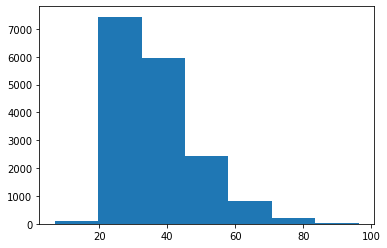

In [42]:
plt.hist(df['Age'], bins=7, histtype='bar', align='right')

Como suspeitávamos, perceba que boa parte dos registros tem idade menor que 31 anos, que era a média de idade antes da imputação no tópico anterior. 

### Discretização Não-Supervisionada com mesmo Intervalo de `IPFPoints`

(array([  26.,  271., 3045., 6104., 5339., 2430.,  574.,   73.,   17.,
           9.]),
 array([  64.89 ,  170.216,  275.542,  380.868,  486.194,  591.52 ,
         696.846,  802.172,  907.498, 1012.824, 1118.15 ]),
 <a list of 10 Patch objects>)

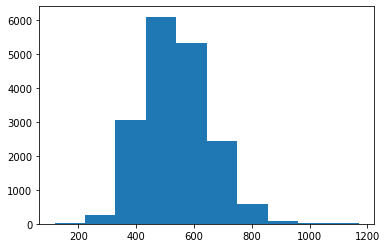

In [43]:
plt.hist(df['IPFPoints'], align='right')

### Discretização Não-Supervisionada com mesma Frequência de `TotalKg`

<function matplotlib.pyplot.show>

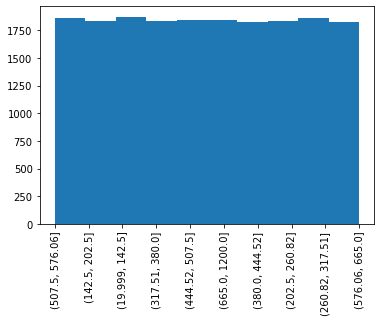

In [61]:
df['TotalKg_disc'] = pd.qcut(df['TotalKg'],10)
df['TotalKg_disc'] = df['TotalKg_disc'].astype('string')
plt.hist(df['TotalKg_disc'])
plt.xticks(rotation=90)
plt.show

Na discretização com mesma frequência, é interessante observar os tamanhos dos intervalos no eixo x. Note, por exemplo, que temos aproximadamente a mesma quantidade de registros com `TotalKg` entre 260 e 317 (tamanho do intervalo: 57) e com `TotalKg` entre 665 e 1200 (tamanho do intervalo: 535).

## Limpeza de Dados

A Limpeza dos Dados é a subetapa do Pré-Processamento que analisa a consistência dos dados. Esta subetapa é responsável por estudar casos em que os dados estejam muito dicrepantes do esperado ou tenham um eventual erro de entrada ou de coleta. 

Vamos averiguar os dados tanto individualmente (métodos de detecção univariados) quanto em conjunto (métodos de detecção bivariados e multivariados).

### Análises Univariadas

In [ ]:
df.dtypes

Unnamed: 0                 int64
Name                      string
Sex                         int8
Event                   category
Equipment               category
Age                      float64
AgeClass                category
Division                category
BodyweightKg             float64
WeightClassKg           category
Squat1Kg                 float64
Squat2Kg                 float64
Squat3Kg                 float64
Best3SquatKg             float64
Bench1Kg                 float64
Bench2Kg                 float64
Bench3Kg                 float64
Best3BenchKg             float64
Deadlift1Kg              float64
Deadlift2Kg              float64
Deadlift3Kg              float64
Best3DeadliftKg          float64
TotalKg                  float64
Place                   category
Wilks                    float64
McCulloch                float64
Glossbrenner             float64
IPFPoints                float64
Tested                  category
Country                 category
Federation

Observando, inicialmente, as colunas do nosso dataframe, destacamos algumas que serão importantes para as estatísticas descritivas e para os testes de hipótese. Dessa forma, vamos fazer a análise univariada das colunas `Age`, `BodyweightKg`, `Best3SquatKg`, `Best3BenchKg`, `Best3DeadlifttKg` e `TotalKg` utilizando o método de Tukey. 

#### `Age`

Primeiro, vamos explorar os valores de tendência da coluna `Age`. Isso nos dará uma ideia da existência ou não de dados inesperados.

In [62]:
df['Age'].describe()

count    16995.000000
mean        30.368473
std         11.647253
min          0.500000
25%         21.711754
50%         27.500000
75%         36.417159
max         90.000000
Name: Age, dtype: float64

In [63]:
df['AgeClass'].cat.categories

Index(['13-15', '16-17', '18-19', '20-23', '24-34', '35-39', '40-44', '45-49',
       '5-12', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-999'],
      dtype='object')

Observe que a idade mínima registrada no dataset é de 6 meses de idade. Note, também, que a categoria de idade mais jovem presente é de 5-12 anos. Isso, juntamente com o nosso conhecimento do domínio, confirma que o registro de 0,5 anos trata-se de um erro.
<br>
Vamos, então, verificar a presença de registros em que `Age` é menor que 5, bem como plotar graficamente a distribuição da idade.

In [64]:
df[df['Age']<5]

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc
1853,1066171,Faith Dickson,0,SBD,Single-ply,0.500000,NaN,Girls,47.08,47.8,NaN,NaN,NaN,74.84,NaN,NaN,NaN,31.75,NaN,NaN,NaN,86.18,192.78,4,258.95,258.95,230.81,351.14,Yes,NaN,THSWPA,2015-01-17,USA,TX,SUNNYVALE INVITATIONAL,-0.77150,-0.921127,-0.673707,-0.707153,-0.785277,-0.456449,"(142.5, 202.5]"
8445,1356135,Bill Henderson,1,SBD,Wraps,0.500000,24-34,MOR,92.50,100,180.0,-195.0,207.5,207.50,167.5,-182.5,-182.5,167.50,205.0,222.5,240.0,240.00,615.00,3,387.33,387.33,373.03,570.67,NaN,New Zealand,UPA,2017-12-09,USA,OH,Old School Iron Gym Winter Attack,-0.21875,-0.334443,0.146667,0.008475,-0.369913,-0.039591,"(576.06, 665.0]"
12327,1187643,Tomas Ring,1,SBD,Single-ply,0.502779,55-59,Masters 2,82.40,83,NaN,NaN,NaN,207.50,NaN,NaN,NaN,197.50,NaN,NaN,NaN,180.00,585.00,2,392.18,488.66,378.62,498.37,Yes,Sweden,SSF,2017-12-08,Sweden,NaN,u/j/v-SM Styrkelyft,-0.21875,-0.204789,-0.173333,-0.042373,-0.462277,-0.176879,"(576.06, 665.0]"


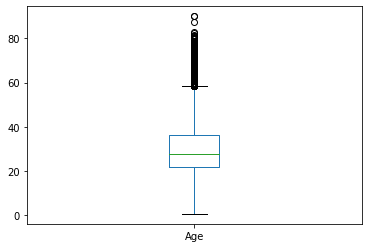

In [65]:
df['Age'].plot.box()

De fato, acontecem casos em que pessoas de mais de 90 anos ainda participam de eventos de powerlifting. Por isso, não excluiremos esses registros. Por outro lado, nota-se claramente que os registros com menos de 5 anos de idade foram errôneos. Essas instâncias serão removidas.

In [66]:
df = df[df['Age']>=5]

In [67]:
df[df['Age']<5]

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc


#### `BodyweightKg`

Da mesma forma que o atributo anterior, vamos verificar valores de tendência para ter uma ideia sobre a coerência dos dados.

In [68]:
df['BodyweightKg'].describe()

count    16886.000000
mean        84.216799
std         23.193949
min         23.600000
25%         66.600000
50%         81.800000
75%         99.200000
max        242.300000
Name: BodyweightKg, dtype: float64

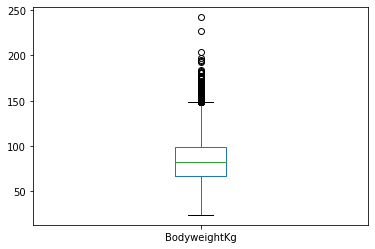

In [69]:
df['BodyweightKg'].plot.box()

In [70]:
print('Registros com BodyweightKg maior que 150:',len(df[df['BodyweightKg']>150]))
print('Registros com BodyweightKg maior que 165:',len(df[df['BodyweightKg']>165]))
print('Registros com BodyweightKg maior que 180:',len(df[df['BodyweightKg']>180]))
print('Registros com BodyweightKg maior que 200:',len(df[df['BodyweightKg']>200]))

Registros com BodyweightKg maior que 150: 139
Registros com BodyweightKg maior que 165: 40
Registros com BodyweightKg maior que 180: 12
Registros com BodyweightKg maior que 200: 3


In [71]:
df[df['BodyweightKg']>200]

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc
3808,627366,James Simmons,1,D,Raw,22.000000,24-34,M_OCR_APF,242.3,140+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,-227.5,-227.5,205.0,205.0,1,108.96,108.96,96.29,275.64,NaN,NaN,APF,2019-03-30,USA,IL,IL State Meet,NaN,NaN,-0.04,-0.686441,1.000000,-0.599814,"(202.5, 260.82]"
5510,815700,Nathan Baptist,1,SBD,Multi-ply,33.500000,24-34,Open,227.5,140+,NaN,NaN,NaN,455.0,NaN,NaN,NaN,310.0,NaN,NaN,NaN,272.5,1037.5,1,551.43,551.43,494.90,526.51,NaN,USA,USPA,2017-07-15,USA,UT,Multi-Ply National Championships,0.8125,0.281414,0.32,0.724576,0.864655,-0.123445,"(665.0, 1200.0]"
17303,1357112,Charles Kadrlik,1,B,Multi-ply,23.808249,24-34,MO,203.7,140+,NaN,NaN,NaN,NaN,277.5,-285.0,-285.0,277.5,NaN,NaN,NaN,NaN,277.5,1,147.49,147.49,135.80,509.12,NaN,NaN,UPA,2007-09-01,USA,IA,Bench Bash For Cash on the MS,NaN,0.140956,NaN,-0.563559,0.647005,-0.156467,"(260.82, 317.51]"


Apesar de parecer inimaginável à primeira vista, de fato existem competidores com mais de 200 kg de peso corporal. Um atleta famoso que se encaixa nessa categoria é Brian Shaw, que, apesar de não competir no powerlifting, é um dos maiores campeões em um esporte similar: o strongman.

Olhando agora para o lado mais leve dos dados, lembramos que a categoria mais jovem é de 5 a 12 anos. Sabendo disso, e que o pseo corporal médio de crianças de 5 anos de idade é 17 kg, conclui-se que não há outliers nessa coluna pelo menos univariadamente

#### `Best3SquatKg`, `Best3BenchKg` e `Best3DeadliftKg`

Para a análise dessas colunas, é importante que sejam notados os recordes mundiais para os eventos, mostrados abaixo (os recordes foram coletados do site da [*International Powerlifting Federation*](https://www.powerlifting.sport/championships/records)).

* Agachamento: 505 kg
* Supino: 425 kg
* Levantamento terra: 420 kg

É importante manter esses valores em mente para detectar possiveís outliers.

In [72]:
df['Best3SquatKg'].describe()

count    12843.000000
mean       174.735897
std         67.697284
min         20.000000
25%        122.500000
50%        167.830000
75%        217.500000
max        500.000000
Name: Best3SquatKg, dtype: float64

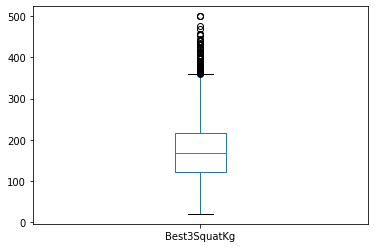

In [73]:
df['Best3SquatKg'].plot.box()

Para o agachamento, não houve nenhum registro acima do recorde mundial de 505 kg.

In [74]:
df['Best3BenchKg'].describe()

count    16219.000000
mean       116.933495
std         53.774329
min         13.500000
25%         72.585000
50%        111.130000
75%        150.000000
max        476.270000
Name: Best3BenchKg, dtype: float64

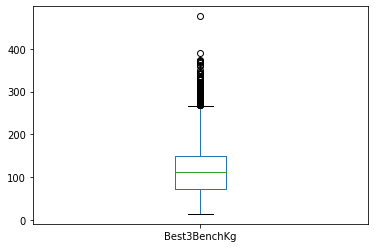

In [75]:
df['Best3BenchKg'].plot.box()

In [78]:
df[df['Best3BenchKg']>425]

,Unnamed: 0,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc
15154,69340,Ryan Kennelly,1,B,Multi-ply,16.5,24-34,Open,156.94,155+,NaN,NaN,NaN,NaN,430.91,476.27,-501.22,476.27,NaN,NaN,NaN,NaN,476.27,1,261.83,261.83,246.64,864.8,NaN,USA,APA,2008-12-01,USA,WA,Northwest Open,NaN,1.0,NaN,-0.226661,0.219387,0.518922,"(444.52, 507.5]"


Para manter a coerência dos dados, excluíremos esse registro.

In [79]:
df.drop(axis=0,index=15154,inplace=True)

In [76]:
df['Best3DeadliftKg'].describe()

count    13767.000000
mean       187.553386
std         61.244508
min         25.000000
25%        140.000000
50%        185.000000
75%        230.000000
max        400.000000
Name: Best3DeadliftKg, dtype: float64

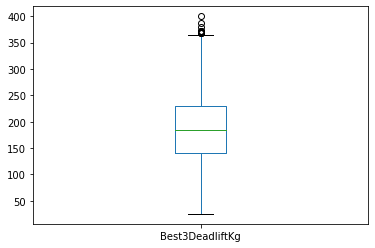

In [77]:
df['Best3DeadliftKg'].plot.box()

No deadlift, também não houve nenhum registro acima do recorde mundial registrado. 

#### `TotalKg`

In [81]:
df['TotalKg'].describe()

count    16991.000000
mean       395.939913
std        201.449961
min         20.000000
25%        232.500000
50%        380.000000
75%        540.000000
max       1200.000000
Name: TotalKg, dtype: float64

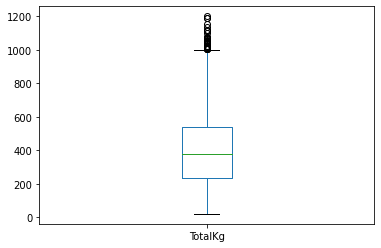

In [ ]:
df['TotalKg'].plot.box()

Aqui, o recorde mundial registrado no mesmo site citado anteriormente foi de 1275 kg. Assim, não houve nenhum valor acima disso.

Dessa forma, concluímos a análise univariada dos dados.

### Análises Multivariadas

Os métodos de detecção multivariados buscam detectar outliers levando em conta mais de um atributo de cada registro. Isso faz com que a limpeza dos dados seja feita de forma mais detalhada, de modo a identificar registros com informações que não condizem com o esperado.

Neste tópico, vamos aplicar técnicas multivariadas de detecção de outliers aos dados estudados nas Análises Univariadas.

Antes, porém, de aplicar os algoritmos em si, devemos examinar esses dados com o objetivo de encontrar possíveis correlações entre os atributos. Isso é importante para avaliar os melhores algoritmos a serem utilizados na análise.

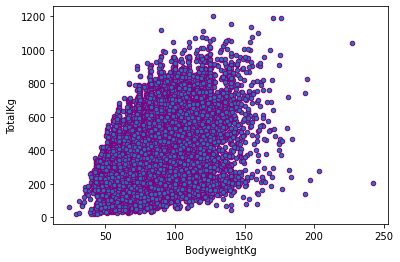

In [87]:
df.plot.scatter(x='BodyweightKg',y='TotalKg', alpha=1, edgecolor='purple')

Logo à primeira vista, é possível identificar pontos que podem ser qualificados como outliers numa análise bivariada inicial. Vamos continuar com essa ideia de comparar peso corporal e carga erguida na célula a seguir.

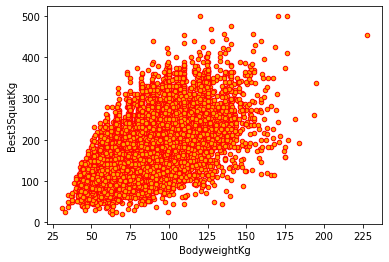

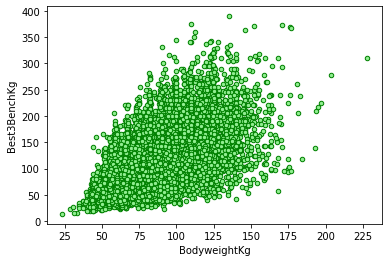

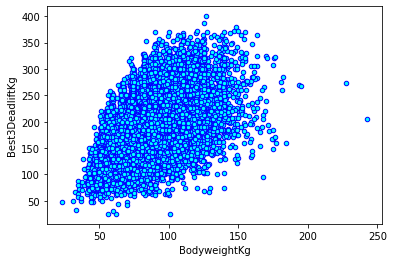

In [100]:
df.plot.scatter(x='BodyweightKg',y='Best3SquatKg', color='orange', edgecolor='red')
df.plot.scatter(x='BodyweightKg',y='Best3BenchKg', color='lightgreen', edgecolor='green')
df.plot.scatter(x='BodyweightKg',y='Best3DeadliftKg', color='cyan',edgecolor='blue')

Em todos os casos, notamos registros que podem ser classificados como outliers. No entanto, para evitar uma análise bivariada exaustiva, faremos uma análisa *multivariada*, que vai levar relacionar todos os atibutos mostrados acima de uma só vez.

Dada a distribuição bivariada dos dados, os algoritmos *Elliptical Envelope* e *Mahalanobis Distance* não parecem se encaixar bem para essa tarefa. Iniciaremos, portanto, pelo algoritmo *Local Outlier Factor*, que considera a densidade dos dados de acordo com a densidade dos seus vizinhos.

In [104]:
len(df)

16991

In [105]:
df.dtypes

Unnamed: 0                 int64
Name                      string
Sex                         int8
Event                   category
Equipment               category
Age                      float64
AgeClass                category
Division                category
BodyweightKg             float64
WeightClassKg           category
Squat1Kg                 float64
Squat2Kg                 float64
Squat3Kg                 float64
Best3SquatKg             float64
Bench1Kg                 float64
Bench2Kg                 float64
Bench3Kg                 float64
Best3BenchKg             float64
Deadlift1Kg              float64
Deadlift2Kg              float64
Deadlift3Kg              float64
Best3DeadliftKg          float64
TotalKg                  float64
Place                   category
Wilks                    float64
McCulloch                float64
Glossbrenner             float64
IPFPoints                float64
Tested                  category
Country                 category
Federation

In [106]:
df_teste=df.copy()

In [108]:
df_teste2=df.loc[:,['Sex','Age','BodyweightKg','TotalKg','Best3SquatKg','Best3BenchKg','Best3DeadliftKg']]
df_teste2.head()

In [109]:
df_teste2.head()

,Sex,Age,BodyweightKg,TotalKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,1,18.000000,88.0,517.50,167.50,122.50,227.50
1,1,46.000000,82.2,180.00,NaN,180.00,NaN
2,1,14.000000,44.0,70.31,NaN,NaN,70.31
3,1,27.995064,92.9,519.36,204.12,129.27,185.97
4,1,46.228441,90.0,145.15,NaN,145.15,NaN


Agora, temos uma cópia do dataframe sobre a qual podemos realizar a detecção. No entanto, o algoritmo de detecção retorna um erro se o dataframe tiver algum valor 'NaN'. Por isso, aplicaremos o KNN já utilizado para todos os atributos do novo dataframe.

In [112]:
df_lof = KNN(k=5).fit_transform(df_teste2);

Imputing row 1/16991 with 0 missing, elapsed time: 56.901
Imputing row 101/16991 with 0 missing, elapsed time: 56.907
Imputing row 201/16991 with 0 missing, elapsed time: 56.912
Imputing row 301/16991 with 2 missing, elapsed time: 56.917
Imputing row 401/16991 with 2 missing, elapsed time: 56.922
Imputing row 501/16991 with 0 missing, elapsed time: 56.927
Imputing row 601/16991 with 0 missing, elapsed time: 56.933
Imputing row 701/16991 with 2 missing, elapsed time: 56.938
Imputing row 801/16991 with 0 missing, elapsed time: 56.945
Imputing row 901/16991 with 0 missing, elapsed time: 56.950
Imputing row 1001/16991 with 2 missing, elapsed time: 56.956
Imputing row 1101/16991 with 0 missing, elapsed time: 56.961
Imputing row 1201/16991 with 0 missing, elapsed time: 56.966
Imputing row 1301/16991 with 0 missing, elapsed time: 56.971
Imputing row 1401/16991 with 0 missing, elapsed time: 56.976
Imputing row 1501/16991 with 0 missing, elapsed time: 56.983
Imputing row 1601/16991 with 2 missi

In [116]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)
scores = clf.fit_predict(df_lof)                    # scores vai receber um array que indica os outliers detectados pelo algoritmo
scores                                              # os outliers sao indicados com score=-1

array([1.02880116, 1.01336229, 1.26165186, ..., 1.40170553, 1.04053219,
       1.08605246])

In [126]:
# Adicionando a coluna com as previsoes de outlier ao dataframe original 

df_comparar = df.copy() # esse dataframe sera usado para propositos de comaparacao
df['lof_outlier'] = scores 

In [127]:
df = df[df['lof_outlier']!=-1] # Removendo os outliers

In [128]:
len(df[df['lof_outlier']==-1])

0

In [ ]:
df_comparar.plot.scatter(x='BodyweightKg',y='Best3SquatKg', color='orange', edgecolor='red')
df_comparar.plot.scatter(x='BodyweightKg',y='Best3BenchKg', color='lightgreen', edgecolor='green')
df_comparar.plot.scatter(x='BodyweightKg',y='Best3DeadliftKg', color='cyan',edgecolor='blue')

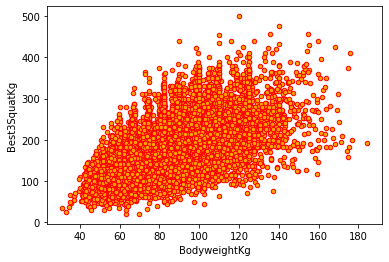

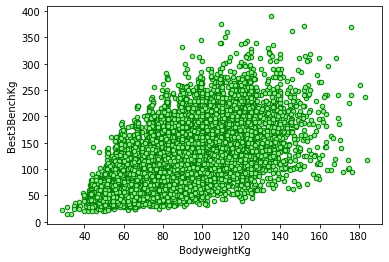

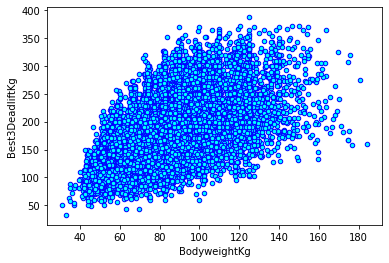

In [129]:
df.plot.scatter(x='BodyweightKg',y='Best3SquatKg', color='orange', edgecolor='red')
df.plot.scatter(x='BodyweightKg',y='Best3BenchKg', color='lightgreen', edgecolor='green')
df.plot.scatter(x='BodyweightKg',y='Best3DeadliftKg', color='cyan',edgecolor='blue')

Como esperado, apesar de ter feito a análise multivariada (em vez de bivariada),podemos ver que os dados muito discrepantes foram, de fato, excluídos. Isso comprova a eficácia do algoritmo trabalhando com variados atributos.

# 3. Estatísticas Descritivas

Neste tópico, buscaremos identificar as características mais importantes do dataset a fim de descrevê-lo e obter *insights* pertinentes. Faremos isso através de recursos gráficos, visando relacionar e correlacionar diferentes atributos.

*Em relação aos Testes de Hipóteses, as Estatísticas Descritivas são uma versão "mais simples". Pode-se pensar neste tópico como sendo um estudo para descrever* **todos** *os registros. Por outro lado, nos Testes de Hipóteses separamos os registros em diferentes grupos e comparamos valores de tendências de atributos entre esses grupos.*

## Peso Corporal x Carga Levantada

Aqui, vamos explorar mais a fundo essa relação que já foi mencionada no tópico da detecção de outliers. 

In [131]:
dfsquat = df[df['Best3SquatKg'].notnull()] # dfsquat contem todos os atletas que participaram do evento de agachamento

In [132]:
dfbench = df[df['Best3BenchKg'].notnull()] # dfbench contem todos os atletas que participaram do evento de supino

In [133]:
dfdead = df[df['Best3DeadliftKg'].notnull()] # dfdead contem todos os atletas que participaram do evento de levantamento terra

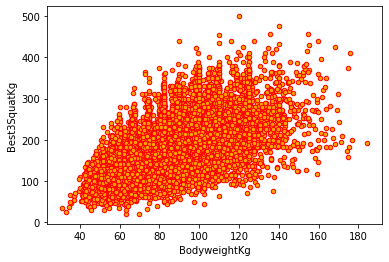

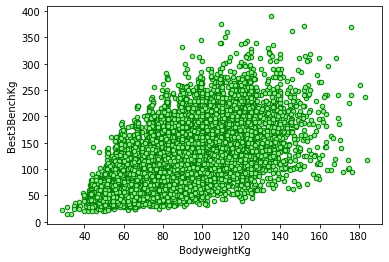

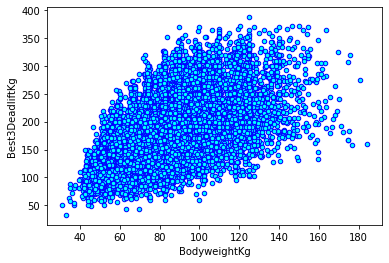

In [140]:
# A ideia eh mostrar graficamente a correlacao entre o peso corporal e a carga erguida em cada evento

#df.plot.scatter(x='BodyweightKg',y='TotalKg', alpha=1, edgecolor='purple')
dfsquat.plot.scatter(x='BodyweightKg',y='Best3SquatKg', color='orange', edgecolor='red')
dfbench.plot.scatter(x='BodyweightKg',y='Best3BenchKg', color='lightgreen', edgecolor='green')
dfdead.plot.scatter(x='BodyweightKg',y='Best3DeadliftKg', color='cyan',edgecolor='blue')

In [145]:
#houses[houses.operation=='sell'].corr(method='pearson')
df.corr(method='pearson').loc['BodyweightKg']

Unnamed: 0             -0.032588
Sex                     0.413000
Age                     0.000859
BodyweightKg            1.000000
Squat1Kg                0.212872
Squat2Kg                0.168975
Squat3Kg                0.082850
Best3SquatKg            0.630194
Bench1Kg                0.291373
Bench2Kg                0.149032
Bench3Kg               -0.033867
Best3BenchKg            0.635543
Deadlift1Kg             0.368178
Deadlift2Kg             0.159752
Deadlift3Kg            -0.042600
Best3DeadliftKg         0.599001
TotalKg                 0.407194
Wilks                   0.039005
McCulloch               0.033565
Glossbrenner            0.058128
IPFPoints               0.119543
Best3SquatKg_norm       0.630194
Best3BenchKg_norm       0.635543
Best3DeadliftKg_norm    0.599001
TotalKg_norm            0.407194
BodyweightKg_norm       1.000000
IPFPoints_norm          0.119543
lof_outlier                  NaN
Name: BodyweightKg, dtype: float64

Os resultados da correlação de Pearson confirmam o esperado a partir dos gráficos: quanto maior o peso corporal, maior tende a ser a carga erguida. Além dos atributos relacionados graficamente, podemos perceber outras correlações, como, por exemplo, a de `BodyweightKg` com `Sex`. O resultado da correlação sugere que homens tendem a pesar mais que mulheres (lembrando que `Sex=1` indica sexo masculino e `Sex=0`, feminino), o que confirma suposições anteriores do nosso conhecimento do domínio.

## Idade x Carga Total Levantada

Aqui, buscaremos relacionar a idade do competidor com a carga erguida em cada um dos exercícios. Isso vai nos dar uma ideia de como a idade afeta o desempenho físico dos atletas e se existe um "pico" de performance em certa idade.

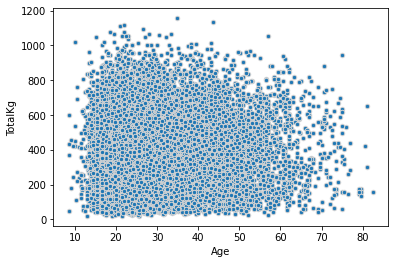

In [150]:
df.plot.scatter(x='Age',y='TotalKg', edgecolor='lightgray')

<BarContainer object of 16676 artists>

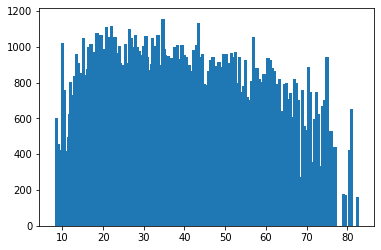

In [152]:
plt.bar(df['Age'], df['TotalKg'])

<BarContainer object of 20 artists>

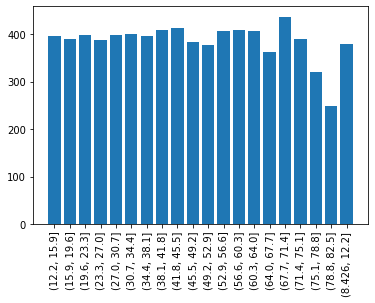

In [183]:
df['Age_disc'] = pd.cut(df['Age'],20)
df['Age_disc'] = df['Age_disc'].astype('string')
plt.xticks(rotation=90)
plt.bar(df.groupby(['Age_disc'])['TotalKg'].mean().index,df.groupby(['Age_disc'])['TotalKg'].mean())

In [184]:
df.groupby(['Age_disc'])['TotalKg'].mean()

Age_disc
(12.2, 15.9]     396.618966
(15.9, 19.6]     389.862802
(19.6, 23.3]     399.310640
(23.3, 27.0]     388.914913
(27.0, 30.7]     397.538406
(30.7, 34.4]     399.965308
(34.4, 38.1]     397.233256
(38.1, 41.8]     409.228433
(41.8, 45.5]     413.250150
(45.5, 49.2]     384.456101
(49.2, 52.9]     378.217102
(52.9, 56.6]     407.120385
(56.6, 60.3]     408.331515
(60.3, 64.0]     407.341503
(64.0, 67.7]     361.955696
(67.7, 71.4]     436.781250
(71.4, 75.1]     390.160250
(75.1, 78.8]     320.574444
(78.8, 82.5]     248.256000
(8.426, 12.2]    378.901220
Name: TotalKg, dtype: float64

<BarContainer object of 20 artists>

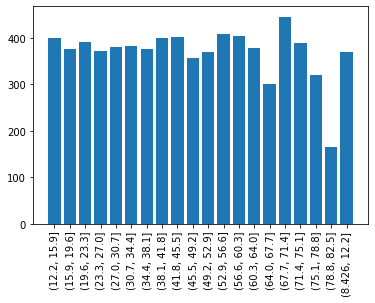

In [185]:
plt.xticks(rotation=90)
plt.bar(df.groupby(['Age_disc'])['TotalKg'].median().index,df.groupby(['Age_disc'])['TotalKg'].median())

In [188]:
df.groupby(['Age_disc'])['TotalKg'].median()

Age_disc
(12.2, 15.9]     400.000
(15.9, 19.6]     375.000
(19.6, 23.3]     390.090
(23.3, 27.0]     371.950
(27.0, 30.7]     380.000
(30.7, 34.4]     382.500
(34.4, 38.1]     376.480
(38.1, 41.8]     399.160
(41.8, 45.5]     401.430
(45.5, 49.2]     356.785
(49.2, 52.9]     370.000
(52.9, 56.6]     409.115
(56.6, 60.3]     403.700
(60.3, 64.0]     377.500
(64.0, 67.7]     300.000
(67.7, 71.4]     445.110
(71.4, 75.1]     388.960
(75.1, 78.8]     319.780
(78.8, 82.5]     166.185
(8.426, 12.2]    370.000
Name: TotalKg, dtype: float64

Surpreendentemente, mesmo dividindo o atributo `Age` dentre várias bins, a média de `TotalKg` não parece variar muito para cada intervalo, com as maiores média e mediana no intervalo de 67 a 71 anos de idade.

# 4. Testes de Hipótese

Os testes de hipótese têm como objetivo confirmar ou refutar suposições feitas anteriormente. Esta etapa está bastante relacionada às estatísticas descritivas de maneira a avaliar conceitos prévios sobre os dados.

A avaliação dos conceitos é feita a partir da comparação de valores de tendência num mesmo grupo em diferentes situações (grupos pariados) ou entre grupos diferentes (grupos não-pariados). Faremos testes de hipótese dos dois tipos.

*A diferença de Estatísticas Descritivas pra Testes de Hipóteses tem alguma coisa a ver com bagui discreto ou continuo. Lembro que o professor falou de diferença de sexo.* ***Atualização*** *: Os testes de hipóteses têm como objetivo fazer perguntas sobre os dados com o intuito de obter insights importantes, a partir de comparação. Ex: peso levantado por homem vs peso levantado por mulher, peso levantado por pessoas de 20-25 anos vs peso levantado por pessoas de 30-35, peso levantado no raw deadlift vs usando straps, etc.*

## Squat x Bench x Deadlift 

Vamos tentar relacionar as cargas levantadas nos diferentes eventos e verificar se há alguma correlação entre eles.

Como suposição inicial, pode-se considerar que a correlação (se houver) entre agachamento e levantamento terra será maior do que a correlação entre supino e agachamento, por exemplo. Isso ocorreria devido à mecânica dos exercícios: o deadlift e o agachamento ambos exigem bastante dos músculos inferiores enquanto que o supino é um exercício quase que exclusivamente dos membros superiores. 
<br>
Agora, vamos avaliar a validade dessa hipótese a partir da correlação de Pearson.


In [197]:
# Para nao haver nenhum impacto de valores nulos, faremos a correlacao apenas para os registros que competiram nos 3 eventos
mask = (df['Best3SquatKg'].notnull())&(df['Best3BenchKg'].notnull())&(df['Best3DeadliftKg'].notnull())
print('Coeficiente de correlacao de Pearson entre "Best3SquatKg" e "Best3BenchKg":',df.loc[mask].corr(method='pearson').loc['Best3SquatKg']['Best3BenchKg'])
print('Coeficiente de correlacao de Pearson entre "Best3SquatKg" e "Best3DeadliftKg":',df.loc[mask].corr(method='pearson').loc['Best3SquatKg']['Best3DeadliftKg'])
print('')
print('Coeficiente de correlacao de Spearman entre "Best3SquatKg" e "Best3BenchKg":',df.loc[mask].corr(method='spearman').loc['Best3SquatKg']['Best3BenchKg'])
print('Coeficiente de correlacao de Spearman entre "Best3SquatKg" e "Best3DeadliftKg":',df.loc[mask].corr(method='spearman').loc['Best3SquatKg']['Best3DeadliftKg'])

Coeficiente de correlacao de Pearson entre "Best3SquatKg" e "Best3BenchKg": 0.9226604971807496
Coeficiente de correlacao de Pearson entre "Best3SquatKg" e "Best3DeadliftKg": 0.9158885571862992

Coeficiente de correlacao de Spearman entre "Best3SquatKg" e "Best3BenchKg": 0.9242854767031202
Coeficiente de correlacao de Spearman entre "Best3SquatKg" e "Best3DeadliftKg": 0.9262370653230507


Como podemos ver, a nossa hipótese inicial foi rejeitada, onde, pela correlação de Pearson, a relação foi exatamente contrária ao suposto anteriormente.

## Primeira x Segunda x Terceira Tentativa

## Diferença entre meninos e meninas de 5-12 anos

## Straps x Deadlift